<a href="https://colab.research.google.com/github/moupriyaroy25/Beginner-s-text-classification/blob/master/PCA__k_means_clusterting_on_Instacart_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

!ls

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec

spark = SparkSession.builder.appName("User Habit").getOrCreate()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 htt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import zipfile

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
aislesdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/aisles.csv/aisles.csv')
departmentdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/departments.csv/departments.csv')
Order_Products_Prior_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/order_products__prior.csv/order_products__prior.csv')
Order_Products_Train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/order_products__train.csv/order_products__train.csv')
ordersdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/orders.csv/orders.csv')
productsdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/instacart-market-basket-analysis/products.csv/products.csv')

In [6]:
Order_Product_Name_Prior = pd.merge(Order_Products_Prior_df, 
                                    productsdf, how='left', on='product_id')
Prior_User_Order_Product = pd.merge(Order_Product_Name_Prior, 
                                    ordersdf, how='left', on='order_id')

In [7]:
Prior = pd.merge(Prior_User_Order_Product,
                                          ordersdf[ordersdf['eval_set']=='train'][['user_id','eval_set']], 
                                          how='inner', on='user_id')
prior = pd.merge(Prior,aislesdf,on=['aisle_id','aisle_id'])

In [8]:
user_habit = prior[['user_id','order_id','product_name','order_dow','order_hour_of_day','days_since_prior_order','aisle']]

In [9]:
user_avg = user_habit.groupby('user_id')['order_dow',
                                'order_hour_of_day',
                                'days_since_prior_order','aisle'].agg(np.nanmean)
# Total number of orders of each user
user_order = user_habit.groupby('user_id').order_id.nunique()
user_avg['num_of_orders'] = user_order
# Total number of products of each user
product_number = user_habit.groupby('user_id')['order_id'].agg('count')
user_avg['num_of_products'] = product_number

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# add product name to each user
name_list = []
for p_name in user_habit.groupby('user_id')['product_name']:
        name_list.append(' '.join(p_name[1]))

# add the names to dataframe
user_avg['product_name'] = name_list
# add aisles to each user
aisle_list = []
for a_name in user_habit.groupby('user_id')['aisle']:
        aisle_list.append(' '.join(a_name[1]))

# add the aisles to dataframe
user_avg['aisle'] = name_list

In [11]:
user_avg.head(5)

,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,product_name,aisle
user_id,,,,,,,
1,2.644068,10.542373,20.259259,10,59,Creamy Almond Butter Organic Unsweetened Vanil...,Creamy Almond Butter Organic Unsweetened Vanil...
2,2.005128,10.441026,15.967033,14,195,Unsweetened Carob Chips Organic Shredded Unswe...,Unsweetened Carob Chips Organic Shredded Unswe...
5,1.621622,15.729730,14.500000,4,37,Large Organic Omega3 Brown Eggs Snow Peas Orga...,Large Organic Omega3 Brown Eggs Snow Peas Orga...
7,1.728155,13.631068,13.546392,20,206,Large Alfresco Eggs Organic Cucumber Organic R...,Large Alfresco Eggs Organic Cucumber Organic R...
8,4.204082,2.448980,30.000000,3,49,Michigan Organic Kale Organic Yams Carrots Org...,Michigan Organic Kale Organic Yams Carrots Org...


In [12]:
product_name_DF = pd.DataFrame(user_avg['product_name'])
sample_frac = 0.2
product_name_DF_sample  = product_name_DF.sample(frac = sample_frac, random_state=321)
sample_user_id  = product_name_DF_sample.index
print(sample_user_id)

Int64Index([160334,  88565,  79012, 169304,  55886, 116927,  97679,   7855,
            135591,  29129,
            ...
            202726,  56964,  66861, 132464, 114757,  17789, 192164,  82482,
            103592,  47895],
           dtype='int64', name='user_id', length=26242)


In [13]:
dataFrameList = []
for row in product_name_DF_sample['product_name']:
    tup = (row.split(' '),)
    dataFrameList.append(tup)
N = len(dataFrameList)//100
mod = len(dataFrameList) % 100
documentDF = spark.createDataFrame(dataFrameList[0:100], ["product_name"])

for i in range(1,N):
    documentDF_sub = spark.createDataFrame(dataFrameList[100*i:100*(i+1)], ["product_name"])
    documentDF = documentDF.union(documentDF_sub)
    
documentDF_sub = spark.createDataFrame(dataFrameList[100*N:len(dataFrameList)], ["product_name"])
documentDF = documentDF.union(documentDF_sub)

In [14]:
word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol="product_name", outputCol="result")
model = word2Vec.fit(documentDF)

res = model.transform(documentDF)
collected=res.collect()

In [15]:
vectorized_features = [ ]
for row in collected:
    text, vector = row
    vectorized_features.append(vector)

In [16]:
vectorized_features_array=[]
for vectors in vectorized_features:
    vectorized_features_array.append(vectors.values)

In [17]:
col_names = []
for i in range(1,6):
    name = "vectorized_feature_" + str(i)
    col_names.append(name)
    
vectorized_features_DF = pd.DataFrame(np.array(vectorized_features_array).reshape(len(dataFrameList),5), 
                 columns = col_names)

vectorized_features_DF['user_id'] = sample_user_id

In [18]:
vectorized_features_DF.head(5)

,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5,user_id
0,0.065815,0.327371,-0.010995,-0.394961,-0.141307,160334
1,-0.522705,0.559774,0.310407,0.418251,-0.016861,88565
2,-0.252800,0.730881,0.219210,-0.228039,-0.013331,79012
3,-0.250875,0.276664,0.082336,-0.236477,-0.030258,169304
4,-0.251736,0.220650,0.133299,-0.379520,-0.010732,55886


**Combine All Features with other vectorized features**

In [19]:
# slice user_avg with sampled user_id
user_avg_sampled = user_avg[user_avg.index.isin(sample_user_id)]
# set index as one column 'user_id'
user_avg_sampled.reset_index(level=0, inplace=True)
# merge two dfs on 'user_id'
user_habit_features = pd.merge(user_avg_sampled, vectorized_features_DF, how='inner', on="user_id")
# drop "product_name"
user_habit_features.drop('product_name', axis=1,inplace=True)
user_habit_features.drop('aisle', axis=1, inplace=True)

In [20]:
user_habit_features.head(5)

,user_id,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5
0,37,3.260638,14.250000,12.687500,23,188,0.008920,0.293017,-0.130434,-0.353501,-0.189571
1,43,2.346939,15.040816,10.549296,11,147,-0.307943,0.260626,-0.184426,-0.114608,0.064979
2,49,2.617021,13.617021,28.522727,8,47,-0.242282,0.231321,-0.077083,-0.358351,0.034329
3,62,2.850000,13.275000,15.772152,10,80,-0.054152,0.082797,-0.202723,-0.329000,-0.332921
4,64,3.888889,15.903704,10.966102,10,135,-0.104657,0.129207,-0.212305,-0.328939,-0.269386


In [21]:
user_habit_features.to_csv('user_habit_features.csv')

In [22]:
user_habit_features_only = user_habit_features.loc[:, 'order_dow':]
user_habit_features_only.to_csv('user_habit_features_only.csv', index=False)

Now apply PCA to reduce features to 2-dimensional

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [26]:
df=pd.read_csv('/content/user_habit_features_only.csv',index_col=0)
df.head(5)

,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5
order_dow,,,,,,,,,
3.260638,14.250000,12.687500,23,188,0.008920,0.293017,-0.130434,-0.353501,-0.189571
2.346939,15.040816,10.549296,11,147,-0.307943,0.260626,-0.184426,-0.114608,0.064979
2.617021,13.617021,28.522727,8,47,-0.242282,0.231321,-0.077083,-0.358351,0.034329
2.850000,13.275000,15.772152,10,80,-0.054152,0.082797,-0.202723,-0.329000,-0.332921
3.888889,15.903704,10.966102,10,135,-0.104657,0.129207,-0.212305,-0.328939,-0.269386


In [27]:
scaler=StandardScaler()
std_data=scaler.fit_transform(df)

In [28]:
pca=PCA()
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [29]:
pca.explained_variance_ratio_

array([9.96643228e-01, 2.43657983e-03, 7.99019885e-04, 1.15660524e-04,
       2.03902916e-06, 1.31254410e-06, 1.24299252e-06, 6.89224968e-07,
       2.28301341e-07])

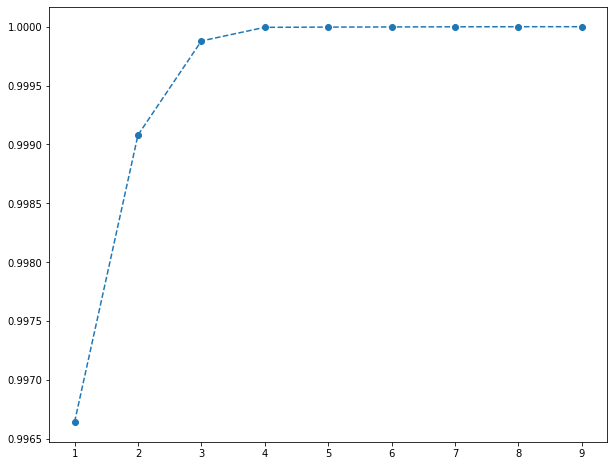

In [30]:
plt.figure(figsize=(10,8))
plt.plot(range(1,10),pca.explained_variance_ratio_.cumsum(), marker='o', linestyle ='--')

In [31]:
pca=PCA(n_components=3)

In [32]:
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [34]:
scores_pca=pca.transform(df)

In [35]:
wcss= []
for i in range(1,21):
  kmean_pca=KMeans(n_clusters=i, init='k-means++',random_state=42)
  kmean_pca.fit(scores_pca)
  wcss.append(kmean_pca.inertia_)

Text(0.5, 1.0, 'no of clusters within squred sum error')

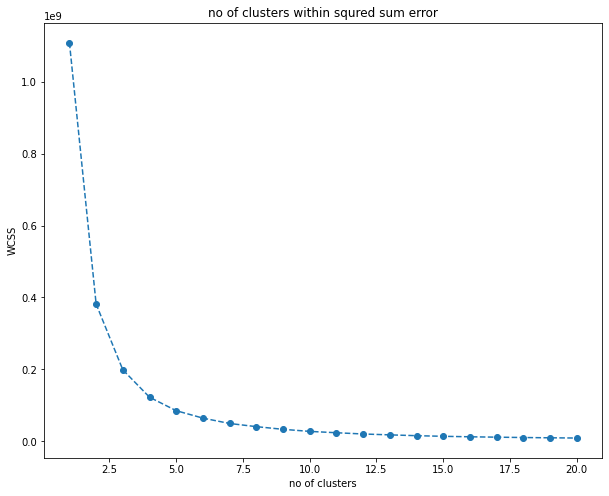

In [37]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21),wcss, marker='o', linestyle ='--')
plt.xlabel('no of clusters')
plt.ylabel('WCSS')
plt.title('no of clusters within squred sum error')

In [38]:
kmean_pca=KMeans(n_clusters=i, init='k-means++',random_state=4)

In [39]:
kmean_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=4, tol=0.0001, verbose=0)

In [46]:
df_pca_kmean= pd.concat([df.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_pca_kmean.columns.values[-3:]=['component 1', 'component 2','component 3']
df_pca_kmean['segment kmean PCA']=kmean_pca.labels_

In [47]:
df_pca_kmean.head(5)

,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5,component 1,component 2,component 3,segment kmean PCA
0,14.250000,12.687500,23,188,0.008920,0.293017,-0.130434,-0.353501,-0.189571,30.851847,-5.841671,0.380781,18
1,15.040816,10.549296,11,147,-0.307943,0.260626,-0.184426,-0.114608,0.064979,-10.814958,1.913086,6.165072,4
2,13.617021,28.522727,8,47,-0.242282,0.231321,-0.077083,-0.358351,0.034329,-111.061964,4.095830,-10.485189,0
3,13.275000,15.772152,10,80,-0.054152,0.082797,-0.202723,-0.329000,-0.332921,-77.806537,0.083650,1.076011,13
4,15.903704,10.966102,10,135,-0.104657,0.129207,-0.212305,-0.328939,-0.269386,-22.860286,2.192423,6.014109,4


In [48]:
df_pca_kmean['segment']=df_pca_kmean['segment kmean PCA'].map({0:'first',1:'second',2:'third',3:'fourth'})

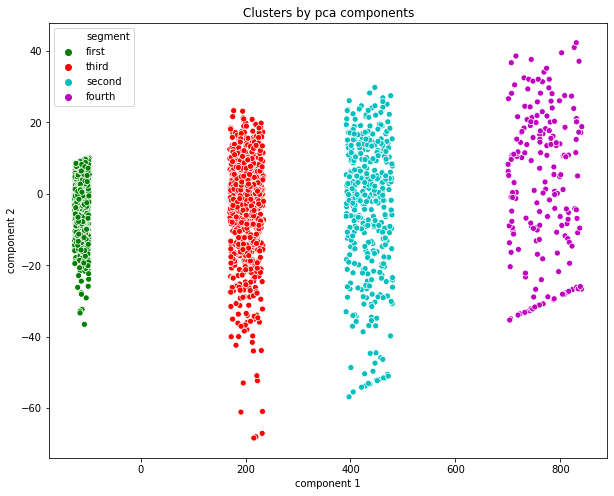

In [49]:
x_axis=df_pca_kmean['component 1']
y_axis=df_pca_kmean['component 2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_kmean['segment'],palette=['g','r','c','m'])
plt.title('Clusters by pca components')
plt.show()

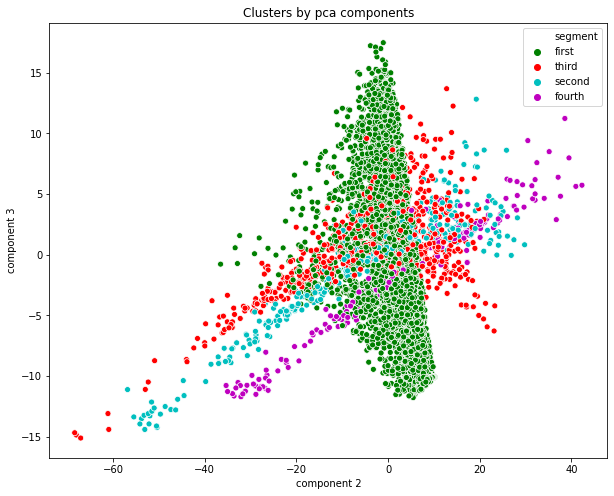

In [53]:
x_axis=df_pca_kmean['component 2']
y_axis=df_pca_kmean['component 3']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_kmean['segment'],palette=['g','r','c','m'])
plt.title('Clusters by pca components')
plt.show()

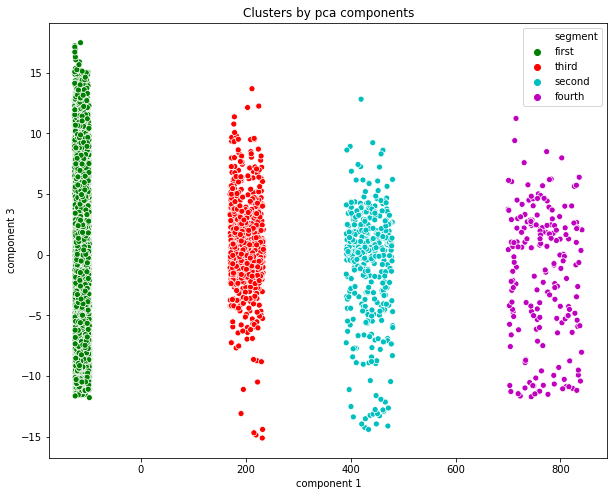

In [55]:
x_axis=df_pca_kmean['component 1']
y_axis=df_pca_kmean['component 3']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_kmean['segment'],palette=['g','r','c','m'])
plt.title('Clusters by pca components')
plt.show()

In [57]:
df_pca_kmean.head(5)

,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5,component 1,component 2,component 3,segment kmean PCA,segment
0,14.250000,12.687500,23,188,0.008920,0.293017,-0.130434,-0.353501,-0.189571,30.851847,-5.841671,0.380781,18,NaN
1,15.040816,10.549296,11,147,-0.307943,0.260626,-0.184426,-0.114608,0.064979,-10.814958,1.913086,6.165072,4,NaN
2,13.617021,28.522727,8,47,-0.242282,0.231321,-0.077083,-0.358351,0.034329,-111.061964,4.095830,-10.485189,0,first
3,13.275000,15.772152,10,80,-0.054152,0.082797,-0.202723,-0.329000,-0.332921,-77.806537,0.083650,1.076011,13,NaN
4,15.903704,10.966102,10,135,-0.104657,0.129207,-0.212305,-0.328939,-0.269386,-22.860286,2.192423,6.014109,4,NaN


In [66]:
df_pca_kmean.to_csv('df_kmean_pca.csv')